# ISING MODEL: simplest model for magnets (Metropolis algorithm)


### Roberto Dionisio Università di Pisa


In [94]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use(['science','notebook','grid'])
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

### Required Facts:
A system in thermal equilibrium with a temperature bath. Probability $p_\mu$ of being in state $\mu$ with energy $E_\mu$ is
$$
p_\mu=\frac{1}{Z}e^{-\beta E_\mu}
$$
where $Z=\Sigma_\mu e^{-\beta E_\mu}$ is the partition function. At equilibrium:
$$
\Sigma_\nu p_\mu P(\mu \rightarrow \nu)= \Sigma_\nu p_\nu P(\nu \rightarrow \mu)
$$
Detailed balance condition:
$$
p_\mu P(\mu \rightarrow \nu)= p_\nu P(\nu \rightarrow \mu
$$


### Ising Model:
spin up or spin down in the ferromagnetic metal; The total energy is :
$$
E_\mu = \Sigma_{<i,j>} -J\sigma_i \sigma_j
$$
where $\sigma_i$ is the spin of a single particle in the lattice (+1 o -1) and the sum means summing over nearest neighbours for all points in the lattice. $\mu$ corresponds to aparticular configuration of the spin. Satisfying the detailed balance:
$$
\frac{P(\mu \rightarrow \nu)}{P(\nu \rightarrow \mu)}=\frac{p_\nu}{p_\mu}=e^{-\beta (E_\nu -E_\mu)}
$$

### Metropolis Algorithm
The idea: Want to find the equilibrium stat $\mu$ in the magnet at a particular temperature $\beta$ (how many $\sigma_i$ are +1 and how many are -1). We'll start with a random lattice of spins, some pointing upand some down, and make it dance around using the equation above until it fixes itself into equilibrium.


#### Routine 
1. Call the current state $\mu$
2. Pick a random on the lattice and flip the spin sign. Call the state $\nu$. We want to find the probability that $P(\mu \rightarrow \nu)$ that we'll accept this new state
3. 
    - if $E_\nu > E_\mu$ than set $P(\nu \rightarrow \mu)=1$ and thus by detailed balance equation $P(\mu \rightarrow \nu)=e^{-\beta(E_\nu - E_\mu)}$.
    - if $E_\mu > E_\nu$ than set $P(\mu \rightarrow \nu)=1$. Still satisfied detailed balance
4. Change to state $\nu$ (i.e. flip the spin of the ion) with the probabilities outlined above
5. Go back to step 1. Repeat many many times and eventually you'll force out an equilibrium state

Thus the only thing that needs to be evaluated is $-\beta(E_\nu-E_\mu)=\beta J \Sigma^4_{k=1} \sigma_i \sigma_k$ where i is the spin being flipped and $\sigma_k$ are the four nearest neighbours to that spin (2D). exceptions for boundaries(less than 4)

Generate a random grid:


In [95]:
#50 by 50 grid
N=50
init_random=np.random.random((N,N))
init_random

array([[0.08926616, 0.7748127 , 0.51503483, ..., 0.9375557 , 0.17832508,
        0.10903768],
       [0.23619587, 0.99121588, 0.27245141, ..., 0.24425643, 0.13375336,
        0.28623057],
       [0.6115488 , 0.16646498, 0.6434422 , ..., 0.1243947 , 0.05138247,
        0.94191633],
       ...,
       [0.34981461, 0.76812898, 0.19069626, ..., 0.46224567, 0.46057153,
        0.47922068],
       [0.55897806, 0.47412514, 0.5450864 , ..., 0.48327669, 0.30658263,
        0.07304145],
       [0.27814255, 0.87920016, 0.2335305 , ..., 0.73530425, 0.85914591,
        0.698637  ]])

In [96]:
init_random=np.random.random((N,N))
lattice_n=np.zeros((N,N))      #75% are negative
lattice_n[init_random>=0.75]=1
lattice_n[init_random<0.75]=-1


init_random=np.random.random((N,N))
lattice_p=np.zeros((N,N))       #75% are positive
lattice_p[init_random>=0.25]=1
lattice_p[init_random<0.25]=-1


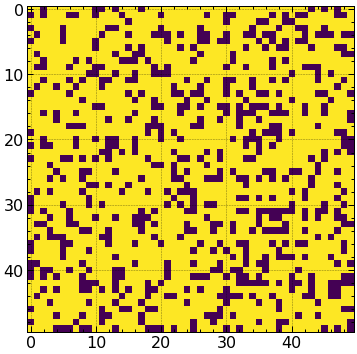

In [97]:
plt.imshow(lattice_p)

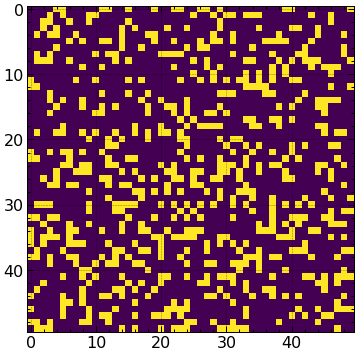

In [98]:
plt.imshow(lattice_n)

Function to get the energy $E/J=-\Sigma \sigma_i \sigma_k$

In [99]:
kern= generate_binary_structure(2,1)
kern[1][1]=False
kern

array([[False,  True, False],
       [ True, False,  True],
       [False,  True, False]])

In [100]:
def get_energy(lattice):
    #nearest neighbpours summation
    kern= generate_binary_structure(2,1)
    kern[1][1]=False
    arr= -lattice * convolve(lattice,kern, mode='constant', cval=0)
    return arr.sum()

In [101]:
get_energy(lattice_p)

-2516.0

## Metropolis Algorithm
1. Takes in the initial grid 2d of spins, number of time steps to run the alogirthm and temperature $BJ$
2. Returns the total spin of all atoms

In [102]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    spin_arr=spin_arr.copy()
    net_spins=np.zeros(times-1)
    net_energy=np.zeros(times-1)
    for t in range(0,times-1):
        #pick rdm point array and flip spin
        x=np.random.randint(0,N)
        y=np.random.randint(0,N)
        spin_i=spin_arr[x,y]  #initial spin
        spin_f=-1*spin_i     #proposed spin flip 
        
        
        
        #Compute change in Energy + boundary conditio
        #when we're computing the change in energy we are intersted only at the site that we have changed and its nearest neighbours
        E_i=E_f=0
        if x>0:
            E_i+= -spin_i*spin_arr[x-1,y]
            E_f+= -spin_f*spin_arr[x-1,y]
            
        if x<N-1:
            E_i+= -spin_i*spin_arr[x+1,y]
            E_f+= -spin_f*spin_arr[x+1,y]
            
        if y>0:
            E_i+= -spin_i*spin_arr[x,y-1]
            E_f+= -spin_f*spin_arr[x,y-1]
            
        if y<N-1:
            E_i+= -spin_i*spin_arr[x,y+1]
            E_f+= -spin_f*spin_arr[x,y+1]
        dE=E_f - E_i
        if(dE>0)*(np.random.random()<np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy+=dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy+=dE
        net_spins[t]= spin_arr.sum()
        net_energy[t]= energy
        
    return net_spins, net_energy

/opt/homebrew/lib/python3.9/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [108]:
spins, energies = metropolis(lattice_n, 1000000, 0.7, get_energy(lattice_n))

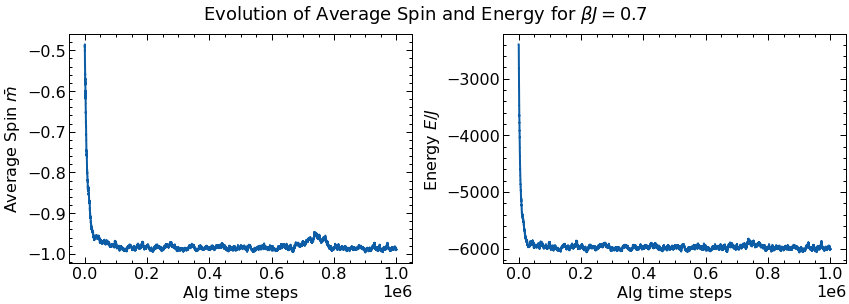

In [109]:
fig, axes=plt.subplots(1,2,figsize=(12,4))
ax=axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Alg time steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax=axes[1]
ax.plot(energies)
ax.set_xlabel('Alg time steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$0.7', y=1.07, size=18)
plt.show()

In [110]:
spins, energies = metropolis(lattice_n, 1000000, 0.2, get_energy(lattice_n))

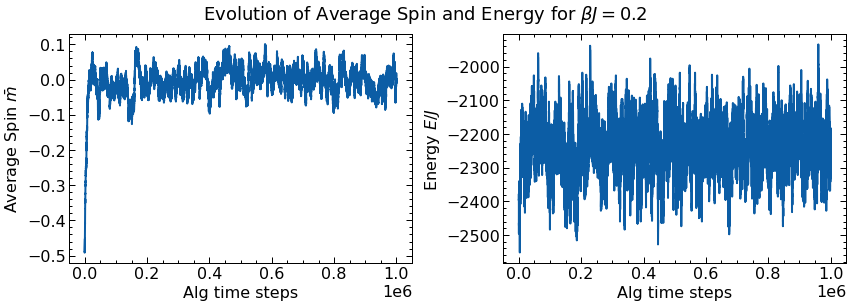

In [111]:
fig, axes=plt.subplots(1,2,figsize=(12,4))
ax=axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Alg time steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax=axes[1]
ax.plot(energies)
ax.set_xlabel('Alg time steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$0.2', y=1.07, size=18)
plt.show()

In [107]:
spins[10]/N**2

-0.4896

Now we can get the average spins and $E/J$ for many values of $\beta J$

In [118]:
def get_spin_energy(lattice, BJs):
    ms=np.zeros(len(BJs))
    E_means=np.zeros(len(BJs))
    E_stds=np.zeros(len(BJs))
    for i,bj in enumerate(BJs):
        spins, energies = metropolis(lattice, 1000000, bj, get_energy(lattice))
        ms[i]=spins[-100000].mean()/N**2
        E_means[i]=energies[-100000:].mean()
        E_stds[i]=energies[-100000:].std()
    return ms,E_means, E_stds
BJs=np.arange(0.1,2,0.02)
ms_n, E_means_n, E_stds_n= get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p= get_spin_energy(lattice_p, BJs)

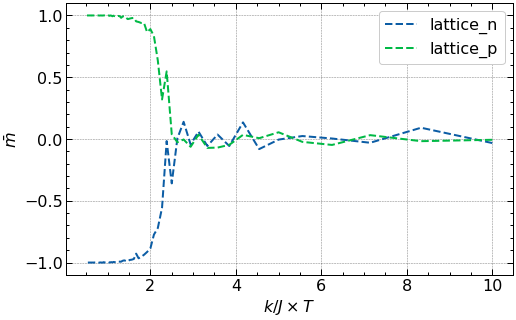

In [119]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n,'--',label='lattice_n')
plt.plot(1/BJs, ms_p,'--',label='lattice_p')
plt.xlabel(r'$k/J \times T$')
plt.ylabel(r'$\bar{m}$')
plt.legend()
plt.show()

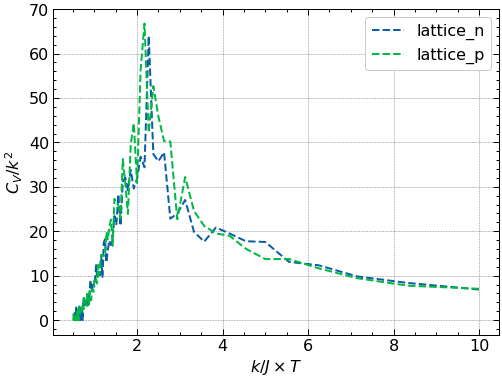

In [120]:
plt.plot(1/BJs, E_stds_n*BJs,'--',label='lattice_n')
plt.plot(1/BJs, E_stds_p*BJs,'--',label='lattice_p')
plt.xlabel(r'$k/J \times T$')
plt.ylabel(r'$C_V/k^2$')
plt.legend()
plt.show()

In [117]:
E_stds_n

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
i=0
isinstance(i, int)


True